# Happiness Team: Predictive Model - Regression on Score

# Abstract

In this notebook, we look to explore how to create a predictive  regression model to make predictions on the expected happiness score based on the following features:

    - GDP per capita
    - Social support
    - Healthy Life Expectancy
    - Freedom to make life choices
    - Perceptions of corruption/Trust in government
    - Generosity
    - country_code
    - latitude
    - longitude
    
These features do not point towards specific countries by name (even if you could determine this from their latitude and longitude). Because of this, we hope to have a model that can learn to value specific features that are good indicators of the expected happiness of a country, given these arbitrary features. We chose to include latitude and longitude because we deemed this and important feature because these features can be indicative of the climate that these countries deal with on averge (close/far from equator/oceans).

## Research Questions

We did not have a main hypothesis to test with our project, but we had several objectives we wanted to accomplish to understand this data set further. To frame our objectives for this project, we restate them here:

1. Understand which features, between the 6 factors focused on by the Gallup survey and the features we pulled in with our additional datasets, contribute the most to happiness.

    - *This is accomplished in the feature importance section of this notebook*

2. Determine if the most important features change over the years, and make a guess as to why.

    - *This is accomplished in the feature importance section of this notebook as well*
    
3. Determine which regions and continents are the happiest across the years.

    - *This is done across our EDA noteboks (EDA_SK.ipynb and EDA_MJ.ipynb)*

4. Determine which latitude and longitude ranges are the happiest (use mean happiness over the years in the happiness reports).

    - *This is done in our EDA notebooks, specifically Jonny's (EDA_JK.ipynb)*

5. Develop a predictive model for Happiness Score based on the main factors to predict the Happiness score for a naive country.

    - *This work is done in this notebook (regression) as well as in our categorical model notebook (HappinessTeam_CategoricalModel.ipynb) and our PCA notebook (HappinessTeam_CategoricalModel.ipynb)*


# Setup: Dataset and Data Preprocessing

In [1]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataset import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

The get_country() function in our main dataset library we built gives us latitude and longitude information.

In [2]:
get_country()

country_code   latitude  longitude               country
0             AD  42.546245   1.601554               Andorra
1             AE  23.424076  53.847818  United Arab Emirates
2             AF  33.939110  67.709953           Afghanistan
3             AG  17.060816 -61.796428   Antigua and Barbuda
4             AI  18.220554 -63.068615              Anguilla
..           ...        ...        ...                   ...
240           YE  15.552727  48.516388                 Yemen
241           YT -12.827500  45.166244               Mayotte
242           ZA -30.559482  22.937506          South Africa
243           ZM -13.133897  27.849332                Zambia
244           ZW -19.015438  29.154857              Zimbabwe

[245 rows x 4 columns]

We then merge these with get_consistent_yearly() to get the data from the world happiness report.

In [3]:
df = get_consistent_yearly().merge(get_country(), left_on="Country or region", right_on="country", how="inner").drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 0 to 1145
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country or region             1146 non-null   object 
 1   Overall rank                  1146 non-null   int64  
 2   Score                         1146 non-null   object 
 3   GDP per capita                1146 non-null   object 
 4   Social support                1146 non-null   object 
 5   Healthy life expectancy       1146 non-null   object 
 6   Freedom to make life choices  1146 non-null   object 
 7   Perceptions of corruption     1145 non-null   object 
 8   Generosity                    1146 non-null   object 
 9   year                          1146 non-null   int64  
 10  country_code                  1139 non-null   object 
 11  latitude                      1146 non-null   float64
 12  longitude                     1146 non-null   float64
 13  cou

We see that we have 157 countries (many countries have data over multiple years of the happiness report).

In [4]:
df.country.nunique()

157

## Data Cleaning

We elect to drop these rows that have NaN values, so we may work with a clean dataset. There is only one, so this should not impact our results.

In [5]:
print(df[df["Perceptions of corruption"].isna()])
df = df.dropna()
df.info()

        Country or region  Overall rank  Score GDP per capita Social support  \
154  United Arab Emirates            20  6.774          2.096          0.776   

    Healthy life expectancy Freedom to make life choices  \
154                    0.67                        0.284   

    Perceptions of corruption Generosity  year country_code   latitude  \
154                       NaN      0.186  2018           AE  23.424076   

     longitude               country  
154  53.847818  United Arab Emirates  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1138 entries, 0 to 1145
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country or region             1138 non-null   object 
 1   Overall rank                  1138 non-null   int64  
 2   Score                         1138 non-null   object 
 3   GDP per capita                1138 non-null   object 
 4   Social support           

We then convert all numerical columns with commas into floating point values, because they are written in Europen numeric notation (with commas).

In [6]:
def to_floats(v):
    if (type(v) == float):
        return v
    elif (type(v) == str):
        return float(v.replace(",", "."))
    
num_features = ["GDP per capita", "Social support", "Healthy life expectancy",
   "Freedom to make life choices", "Perceptions of corruption", "Generosity", "latitude", "longitude"]
    
for feature in num_features + ["Score"]:
    df[feature] = df[feature].apply(to_floats)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1138 entries, 0 to 1145
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country or region             1138 non-null   object 
 1   Overall rank                  1138 non-null   int64  
 2   Score                         1138 non-null   float64
 3   GDP per capita                1138 non-null   float64
 4   Social support                1138 non-null   float64
 5   Healthy life expectancy       1138 non-null   float64
 6   Freedom to make life choices  1138 non-null   float64
 7   Perceptions of corruption     1138 non-null   float64
 8   Generosity                    1138 non-null   float64
 9   year                          1138 non-null   int64  
 10  country_code                  1138 non-null   object 
 11  latitude                      1138 non-null   float64
 12  longitude                     1138 non-null   float64
 13  cou

Here, we create the feature matrix, labels, and perform train-test split. Once we have our data points, we want to fit a standard scaler to the training data, which will be our final features that we work for building a predictive model. We keep samples from the same country/region in the same sets because we don't want the testing set to include similar countries from our training set, where it can incorrectly overfit on the data. We create a 80/10/10 split for our training, validation, and testing sets.

In [8]:
def train_val_test(df, cols, val_size=0.1, test_size=0.1):
    train_size = 1 - val_size - test_size
    unique_countries = df.country.unique()
    np.random.shuffle(unique_countries)
    train_countries = unique_countries[:int(unique_countries.shape[0] * train_size)]
    val_countries = unique_countries[int(unique_countries.shape[0] * train_size):int(unique_countries.shape[0] * (train_size + val_size))]
    test_countries = unique_countries[int(unique_countries.shape[0] * (train_size + val_size)):]
    # make sets
    X_train = df[cols][df.country.isin(train_countries)]
    y_train = df[df.country.isin(train_countries)].Score
    X_val = df[cols][df.country.isin(val_countries)]
    y_val = df[df.country.isin(val_countries)].Score
    X_test = df[cols][df.country.isin(test_countries)]
    y_test = df[df.country.isin(test_countries)].Score
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(df, num_features)

We then perform scaling on our dataset to assure that we don't have any unexpected biases towards certain features.

In [9]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_val = scale.transform(X_val)
X_test = scale.transform(X_test)

# Data Modeling & Prediction

In our modeling section, we evaluate and SGDRegressor and two different neural network structurings to see what produces the lowest RMSE for our model. The tradeoff between these two models is that while the SGDRegressor is more interpretable because it is just a linear weighting of our features, it cannot capture as much of the complexity of our relationships compared to neural networks, which have more parameters. We output their losses for comparison at the end of this section.

## Baseline

To determine if our model is making any improvements from a baseline model, we create a dummy regressor that just guesses the mean score in the data set.

In [10]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

DummyRegressor()

## SGDRegressor

Suppose we have n features that we are trying to make a linear approximation for. We compute the prediction as:

$$ y = \vec{w} \cdot \vec{x} + b $$

where \\(\vec{w}\\) is the weights vector and b is the bias. This approach learns the weights and intercept based on the loss function it has using stochastic gradient descent. The loss for this is the square error.

In [11]:
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

SGDRegressor()

## Neural Network (1 Hidden Layer)

This neural network would go from our original 8 features (lat, long, and world happiness features) to an output of a singular value. There is on hidden layer with 10 neurons in between, so the mathematical representation of this network would be:

$$ \vec{y_{pred}} = (\vec{x} \space W) \space M $$

where \\(\vec{x}\\) would be 1 x 8, W would be 8 x 10, and M would be 10 x 1. By having more weights, we would expect to see an improvment in the loss of this network compared to the SGD regressor.

In [12]:
def create_model_1_hidden():
    return keras.Sequential(
        [
            layers.Dense(10, activation="relu", name="dense1", input_shape=(X_train.shape[1],)),
            layers.Dense(1, name="output")
        ]
    )

model = create_model_1_hidden()
model.compile(loss="mean_squared_error", optimizer="sgd")
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 10)                90        
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model.fit(X_train, y_train, epochs=8, batch_size=2)

Epoch 1/8
451/451 [==============================] - 3s 4ms/step - loss: 1.0492
Epoch 2/8
451/451 [==============================] - 2s 4ms/step - loss: 0.3269
Epoch 3/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2800
Epoch 4/8
451/451 [==============================] - 2s 3ms/step - loss: 0.2666
Epoch 5/8
451/451 [==============================] - 2s 3ms/step - loss: 0.2572
Epoch 6/8
451/451 [==============================] - 2s 3ms/step - loss: 0.2515
Epoch 7/8
451/451 [==============================] - 2s 3ms/step - loss: 0.2448
Epoch 8/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2466


## Neural Network (2 Hidden Layers)

This model would be similar to the previous neural network, going from 8 features to 1 output value that we optimize for. However, we will now have an additional 10 x 12 hidden layer added after our first hidden layer to allow the model to be able to capture relationships that are typically more non-linear.

Equation:


$$ \vec{y_{pred}} = ((\vec{x} \space W_1) \space W_2) \space W_3 $$

In [14]:
def create_model_2_hidden():
    return keras.Sequential(
        [
            layers.Dense(10, activation="relu", name="dense1", input_shape=(X_train.shape[1],)),
            layers.Dense(12, activation="relu", name="dense2"),
            layers.Dense(1, name="output")
        ]
    )
    
model2 = create_model_2_hidden()
model2.compile(loss="mean_squared_error", optimizer="sgd")
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 10)                90        
                                                                 
 dense2 (Dense)              (None, 12)                132       
                                                                 
 output (Dense)              (None, 1)                 13        
                                                                 
Total params: 235
Trainable params: 235
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
model2.fit(X_train, y_train, epochs=8, batch_size=2)

Epoch 1/8
451/451 [==============================] - 3s 4ms/step - loss: 0.9509
Epoch 2/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2779
Epoch 3/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2640
Epoch 4/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2511
Epoch 5/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2454
Epoch 6/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2403
Epoch 7/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2300
Epoch 8/8
451/451 [==============================] - 2s 4ms/step - loss: 0.2325


## Comparing Losses Between Models

From looking at our models, we see that we have the lowest MSE and MAE on the validation sets typically from the SGD Regrssor (this sometime varies if we rerun). This is most likely because with a larger model as we see in our neural networks, we may be overfitting our data, so these models cannot generlize as well as the SGD Regressor, which only has 9 parameters.

In [16]:
def mse(model, X, y_label):
    y_pred = model.predict(X).flatten()
    return ((y_pred - y_label) ** 2).mean()

def mae(model, X, y_label):
    y_pred = model.predict(X).flatten()
    return (y_pred - y_label).abs().mean()

In [17]:
results = []
results.append(("Dummy Regressor (Baseline)",
                mae(dummy, X_train, y_train), 
                mse(dummy, X_train, y_train), 
                mae(dummy, X_val, y_val), 
                mse(dummy, X_val, y_val)))
results.append(("SGD Regressor",
                mae(sgd, X_train, y_train), 
                mse(sgd, X_train, y_train), 
                mae(sgd, X_val, y_val), 
                mse(sgd, X_val, y_val)))
results.append(("Neural Network (1 Hidden Layer)", 
                mae(model, X_train, y_train), 
                mse(model, X_train, y_train), 
                mae(model, X_val, y_val), 
                mse(model, X_val, y_val)))
results.append(("Neural Network (2 Hidden Layer)", 
                mae(model2, X_train, y_train), 
                mse(model2, X_train, y_train), 
                mae(model2, X_val, y_val), 
                mse(model2, X_val, y_val)))
results = pd.DataFrame(results, columns=["Model", "MAE_train", "MSE_train", "MAE_val", "MSE_val"])
results.head()

4/4 [==============================] - 0s 4ms/step


Model  MAE_train  MSE_train   MAE_val   MSE_val
0       Dummy Regressor (Baseline)   0.989637   1.398219  0.649951  0.635090
1                    SGD Regressor   0.393417   0.266925  0.434642  0.283949
2  Neural Network (1 Hidden Layer)   0.402844   0.248601  0.521752  0.417376
3  Neural Network (2 Hidden Layer)   0.353309   0.198707  0.477262  0.302721

# Feature Importance

What is measured:

- We measure the original error/loss of our model and then permute a given feature. If our error increases significantly, that means this feature was very important. If our error does not increase, that means the feature is not very important.

In [41]:
def feature_importance(X, y, model, cols, is_tf=False):
    scores = []
    if is_tf:
        y_pred = model.predict(X, verbose=0).flatten()
    else:
        y_pred = model.predict(X).flatten()
    mse_original = ((y - y_pred) ** 2).sum()
    for i, feature in enumerate(cols):
        X_copy = np.copy(X)
        np.random.shuffle(X_copy[:, i]) # random permutation
        if is_tf:
            y_pred = model.predict(X_copy, verbose=0).flatten()
        else:
            y_pred = model.predict(X_copy).flatten()
        mse_perm = ((y -y_pred) ** 2).sum()
        feature_importance = mse_perm / mse_original
        scores.append((feature_importance, feature))
    return list(reversed(sorted(scores)))

def plot_feature_importance(fi, model):
    fi = np.array(fi)
    plt.bar(fi[:, 1], np.array(fi[:, 0], dtype="float64"))
    plt.title(f"Feature Importance: {model}")
    plt.tick_params(axis="x", rotation=90)
    plt.show()

## SGDRegressor

We see here that that GDP is the most important feature, followed by freedom to make life choices. Latitude and longitude do not play as much of a role here.

GDP per capita: 2.1835981093908163
Healthy life expectancy: 1.7051479793461428
Freedom to make life choices: 1.4367874386436406
Social support: 1.343012476087511
longitude: 1.299664106701135
Perceptions of corruption: 1.1644667236527446
Generosity: 1.073345638534934
latitude: 1.0417826423448893


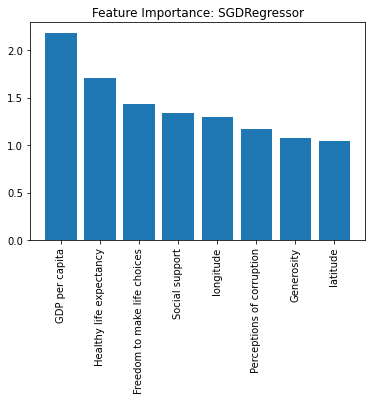

In [42]:
fi_sgd = feature_importance(X_train, y_train, sgd, num_features)
print("\n".join([f"{feature}: {importance}" for importance, feature in fi_sgd]))
plot_feature_importance(fi_sgd, "SGDRegressor")

## Neural Network (1 Hidden Layer)

While GDP per capita remains the most important feature, we can see that with a hidden layer, the latitude and longitude starts to become more important to the model's decisions.

longitude: 2.006606616130701
GDP per capita: 1.8285434507683125
latitude: 1.4954161215495714
Healthy life expectancy: 1.3448532196467198
Freedom to make life choices: 1.3415979453078057
Social support: 1.3246435087229353
Generosity: 1.1253548835055134
Perceptions of corruption: 1.0892908687635623


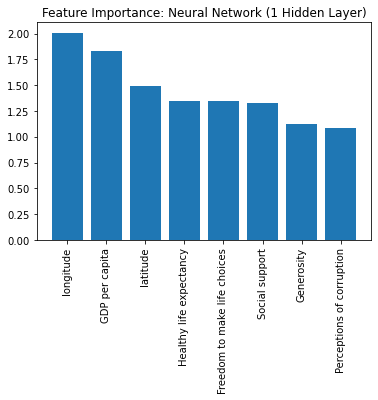

In [43]:
fi_nn = feature_importance(X_train, y_train, model, num_features, is_tf=True)
print("\n".join([f"{feature}: {importance}" for importance, feature in fi_nn]))
plot_feature_importance(fi_nn, "Neural Network (1 Hidden Layer)")

## Neural Network (2 Hidden Layers)

The results are very similar to the neural network with a single hidden layer, as we see once again that longitude and latitude are muc more important compared to the SGD regressor.

longitude: 1.878105798749576
GDP per capita: 1.790674653558403
latitude: 1.5021874808962044
Freedom to make life choices: 1.3642815966120978
Healthy life expectancy: 1.3601737386746329
Social support: 1.3306696946588519
Perceptions of corruption: 1.1082251504609635
Generosity: 1.1056345314945966


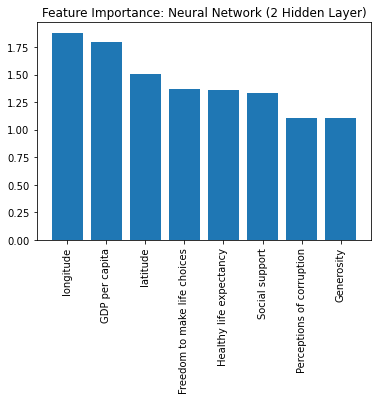

In [44]:
fi_nn2 = feature_importance(X_train, y_train, model, num_features, is_tf=True)
print("\n".join([f"{feature}: {importance}" for importance, feature in fi_nn2]))
plot_feature_importance(fi_nn2, "Neural Network (2 Hidden Layer)")

## Feature Importance By Year

One of the questions we set out to understand through this project was if important features change by year. This was motivated by the thought that for different years, there may certain events that end up shaping what humans end up valuing as important when they responded to the survey.

Getting Feature Importance for 2015
Getting Feature Importance for 2016
Getting Feature Importance for 2017
Getting Feature Importance for 2018
Getting Feature Importance for 2019
Getting Feature Importance for 2020
Getting Feature Importance for 2021
Getting Feature Importance for 2022


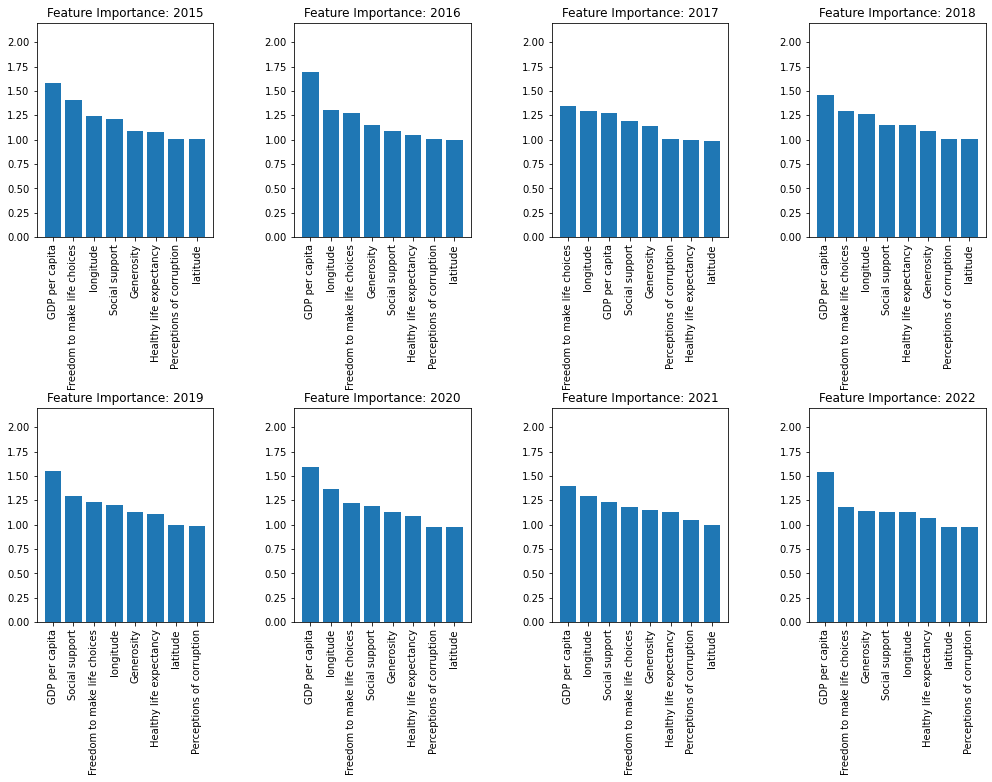

In [30]:
ROWS, COLS = 2, 4
fig, axs = plt.subplots(ROWS, COLS)
fig.set_size_inches(15, 10)
fig.tight_layout(pad=5, h_pad=15)

ind = 0
max_ = 0

for year in range(df.year.min(), df.year.max() + 1):
    print(f"Getting Feature Importance for {year}")
    year_data = df[df.year == year]
    X_train_yr, X_val_yr, X_test_yr, y_train_yr, y_val_yr, y_test_yr = train_val_test(year_data, num_features)
    
    scale = StandardScaler()
    X_train_yr = scale.fit_transform(X_train_yr)
    X_val_yr = scale.transform(X_val_yr)

    # create the model and fit it
    year_model = SGDRegressor()
    year_model.fit(X_train, y_train)
    
    # calculate feature importances
    fi_yr_model = feature_importance(X_val, y_val, year_model, num_features)

    # add to plot
    fi_yr_model = np.array(fi_yr_model)
    max_ = max(max_, np.array(fi_yr_model[:, 0], dtype="float64").max())
    ax = axs[ind // COLS, ind % COLS]
    ax.bar(fi_yr_model[:, 1], np.array(fi_yr_model[:, 0], dtype="float64"))
    ax.set_title(f"Feature Importance: {year}")
    ax.tick_params(axis="x", rotation=90)
    ind += 1

for i in range(df.year.max() + 1 - df.year.min()):
    axs[i // COLS, i % COLS].set_ylim([0, max_ + 0.5])
    
plt.show()

# Evaluating on Test Set

Now that we have established that the SGD Regressor seems to do the best at not overfitting the data, we can evalute it on the test set, which it appears to do well on.

In [25]:
print(f"Testing Set with SGDRegressor:\n - MAE: {mae(sgd, X_test, y_test)} \n - MSE: {mse(sgd, X_test, y_test)}\n")
print(f"Testing Set with Dummy Regressor:\n - MAE: {mae(dummy, X_test, y_test)} \n - MSE: {mse(dummy, X_test, y_test)}")

Testing Set with SGDRegressor:
 - MAE: 0.32823813445177646 
 - MSE: 0.18204919344316045

Testing Set with Dummy Regressor:
 - MAE: 0.7506650328359086 
 - MSE: 0.7971592513820599


We can see from the predictions, the model can generally predict in the vicinity of the features, but it is not always perfect.

In [29]:
y_pred = sgd.predict(X_test)
res_df = pd.DataFrame({"y_pred": y_pred, "y_actual" : y_test.to_numpy()}).sort_values(by="y_actual")
res_df

y_pred  y_actual
75   4.612661    3.7594
77   4.691578    3.7600
76   4.183829    4.0730
74   4.734932    4.1070
112  4.632847    4.1200
..        ...       ...
13   7.279920    7.2375
1    5.958616    7.2670
0    6.154443    7.2780
14   6.950844    7.3240
7    6.707660    7.3640

[121 rows x 2 columns]

We can also easily interpret this model by looking at the weights that were generated for this regressor. We see once again that the most heavily weighted features are GDP per capita and Healthy life expectancy, which aligns with our results from feature importance.

In [34]:
print("\n".join([f"{feature}: {weight}" for feature, weight in zip(num_features, sgd.coef_)]))

GDP per capita: 0.39198607349901343
Social support: 0.21407253455568312
Healthy life expectancy: 0.28897548911909854
Freedom to make life choices: 0.23665087076251531
Perceptions of corruption: 0.13431669109224217
Generosity: 0.1034415976144548
latitude: 0.07643303649048905
longitude: -0.20772704488564622


# Result Analysis

Based on the results of this notebook, we can analyze our results to try and answer the following original objectives:

**1. Understand which features, between the 6 factors focused on by the Gallup survey and the features we pulled in with our additional datasets, contribute the most to happiness.**

Through calculating the feature importance, we saw that *GDP per capita* and *Healthy Life Expectancy* tended to be the most important features. On the other hand, generosity, perceptions of corruption, and latitude/longitude tended to be not as important.
    
Although this is strictly conjecture, we can propose that this may happen because there may be features that we consider to be "golidlocks" features. Feature likes Perceptions of Corruption may be too broad and abstract to affect the happiness of citizens. On the contrary, generosity might be too citizen specific that the acts don't impact the happiness of the country as a whole significantly. GDP per capita and healthy life expectancy may be the most predictive features because these factors impact the lives of everyone, as everyone wants to have money to allow them some financial freedom in their life and everyone wants to have a long life to spend this money they make.

**2. Determine if the most important features change over the years, and make a guess as to why.**

Similar to the feature importance we saw across the whole dataset, we saw that GDP per capita and healthy life expectancy remained some of the more important features while generosity and perceptions of corruption tended to be less important. 
    
While there was some varitation, there was not a big notable shift that we can draw any new hypotheses from. One of the original motivations of this question was that because COVID occurred halfway through the years we have in our data set, this may have changed what made citizens happy. There was no evidence of such, so we can reject this idea.

**5. Develop a predictive model for Happiness Score based on the main factors to predict the Happiness score for a naive country.**

From our predictive modeling, we found that for regression an SGD regressor (uses gradient descent to come to an optimal linear transformation of our features) was our best model in terms of being able to generalize to new samples. Our neural networks performed well on the training set, but even with a small model size, we ended up still overfitting because having these hidden layers most likely allowed the model to capture more complex relationships it saw in the training set.
    
When we evaluated our SGD Regressor on the testing set, we saw that it had a MAE of around .328 and a MSE around .182, which is fairly good performance, as our scores can range in value from scores of 4 up to 8. This may not be a great model for getting a precise measurement, but it seems like it may be a good estimator. Looking at the weights of this model, we saw that the most heavily weighted features were GDP per capita and healthy life expectancy, which aligns with our findings from EDA and our feature importance analysis.

## Overall Analysis / Feedback

Overall, this project went reasonably well. We found it difficult at first because this is not like a traditional software engineering project where we can communicate code with git very effectively. Because of this, we adjusted our process to have the multiple notebooks that we ended up with. In doing this though, I feel like we ended up sometimes writing data setup code that was redundant across multiple notebooks. I think in future projects, any code that we would like to share should be put into physical Python modules because those can be handled better with git in the case of merge conflicts etc.

From an analaysis standpoint, we could have improved on our analysis by potentially experimenting with using data across different years to build our model. This would have addressed our fear of potentially having a model that learns to sum the features given to it if we used the previous year to predict the next year. From a regression standpoint, I could have performed feature selection, but I instead took the route of examining feature importance. ***Ideally, I would have done both, but there is just so much work to do that it becomes hard to decide what is important and what is not.***

From an overall feedback standpoint/as a question to you, how do you define in a data science project what is our work limit? You have seen our work throughout the quarter and we have always had the crisis of knowing when to call our work sufficient because in data science, it feels like we can always understand our data a little bit more. ***Do you have any tips/stories to share with how you address this struggle?***

# Resources

- [numpy.random.shuffle](https://appdividend.com/2020/06/04/np-random-shuffle/#:~:text=np.random.shuffle%201%20Syntax%20numpy.random.shuffle%20%28seq_name%29%202%20Parameters%20The,shuffling%20using%20arange%20%28%29%20and%20shuffle%20%28%29%20)

- [pandas.DataFrame.sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html)

- [Feature Importance Calcuation](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

- [Keras Sequential Model](https://keras.io/guides/sequential_model/)

- [Keras Compilaton](https://www.tutorialspoint.com/keras/keras_model_compilation.htm)